In [15]:
# Call packages
using Pkg
Pkg.add("Plots")
Pkg.add("Optim")

using Plots

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [16]:
# Write a solver for Kepler's equation given M, e

function FIND_E(M, e)
    # Constraining the number of iterations
    n_iterations = 0
    
    # Functions
    g(E, e, M) = E - e * sin(E) - M
    dg_dE(E, e) = 1 - e * cos(E)
    
    # Starting point
    E_0 = M + 0.85 * e * sign(sin(M))
    
    while abs(g(E_0, e, M)) > 2e-16 && n_iterations < 100
        
        # Iterate to find E
        E_0 = E_0 - (g(E_0, e, M) / dg_dE(E_0, e))
        
        # Count number of iterations
        n_iterations += 1
    
    end
    return E_0
end

FIND_E (generic function with 1 method)

In [17]:
# Show that the solver gives the correct answer, testing against g(E, e, M)

# Function
g(E, e, M) = E - e * sin(E) - M

# Set up lists for all cases of M, extreme cases of e
e_0 = []
e_1 = []

# Evaluate g(E, e, M) given values of E found by the solver
for M = range(0, stop=2*pi, length=1000)
    push!(e_0, g(FIND_E.(M,0.001), 0.001, M))
    push!(e_1, g(FIND_E.(M,0.999), 0.999, M))
end

# Validate that the solver creates values of E that result in "zero" values for g(E, e, M)
println("Minimum and maximum values for e ~ 0:")
println(minimum(e_0), " ; ", maximum(e_0))

println()

println("Minimum and maximum values for e ~ 1:")
println(minimum(e_1), " ; ", maximum(e_1))

Minimum and maximum values for e ~ 0:
-4.440892098500626e-16 ; 1.1102230246251565e-16

Minimum and maximum values for e ~ 1:
-8.881784197001252e-16 ; 8.881784197001252e-16


**Because g(E, e, M) always returns values that are roughly equal to zero given E from our solver, we know that the solver offers correct values for E.**

0.0:0.006289474781961547:6.283185307179586


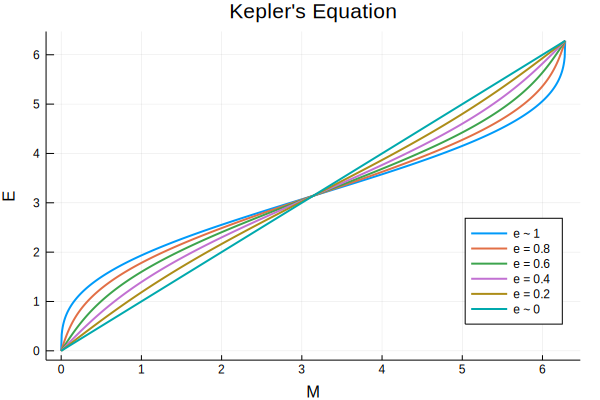

In [30]:
# Test the solver on all possible values of M, e

# Include all possible values of M
M = range(0, stop=2*pi, length=1000)
println(M)

# Find E for incremental values of e = (0, 1)
E = hcat(FIND_E.(M,0.999), FIND_E.(M,0.8), FIND_E.(M,0.6), 
    FIND_E.(M,0.4), FIND_E.(M,0.2), FIND_E.(M,0.001))

#Plot the results
plot(M, E, title="Kepler's Equation", xlabel="M", ylabel="E", legend=:bottomright,
    label=["e ~ 1" "e = 0.8" "e = 0.6" "e = 0.4" "e = 0.2" "e ~ 0"], lw = 2)

# Leah Fulmer + Debby Tran - Exoplanets Winter 2019 - Homework 1b

In [19]:
# Write a function to implement the radial velocity formula for a planet on an elliptical orbit
# Variables:
## P = orbital period
## e = eccentricity
## t_p = time of periastron
## time = current time
## gamma = barycenter velocity with respect to observer (along the line of sight)
## omega = longitude of pericenter
## K = semi-amplitude


# NOTE: ONLY NEED FIND_Vrad(P, e, t_p)
# Use method from required paper to solve the rest of these explicitly

function FIND_Vrad(P, e, t_p, time, gamma, omega, K)
    # Find f given our solver for Kepler's equation
    M = ((2 * pi) / P) * (time - t_p)
    E = FIND_E(M, e)
    f = 2 * atan(((1 + e)/(1 - e))^(1/2) * tan(E/2))
    
    # Find the remaining values for our Vrad equation: h, c, and V0
    h = K * cos(omega)
    c =  -K * sin(omega)
    V0 = gamma + K * e * cos(omega)
    
    # Solve for Vrad
    Vrad = h * cos(f) + c * sin(f) + V0
    return Vrad
end

FIND_Vrad (generic function with 1 method)

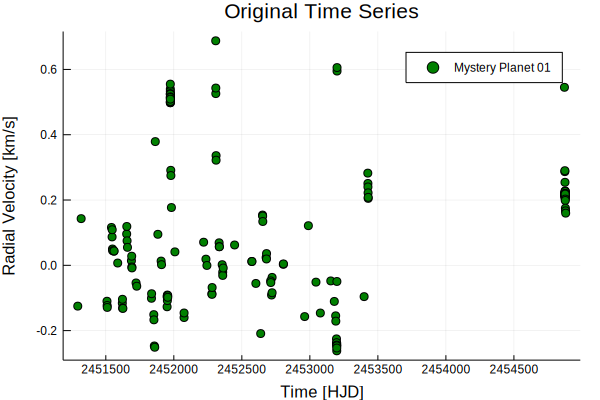

In [20]:
# Find the period of the planet in the RV dataset contained in mystery_planet01.txt

# Call packages
using DelimitedFiles

# Read in the data for Mystery Planet 01
mystery_planet01 = readdlm("mystery_planet01.txt")

# Isolate the values for time, radial velocity, and radial velocity error
time = mystery_planet01[:,1]
RV = mystery_planet01[:,2]
error = mystery_planet01[:,3]

# Plot the time series for Mystery Planet 01
plot(time, RV, seriestype=:scatter, label="Mystery Planet 01", title="Original Time Series", 
    xlabel="Time [HJD]", ylabel="Radial Velocity [km/s]", seriescolor=:green)

In [21]:
function FIND_P(time, RV)
    periods = []
    sum_point_distances = []
    
    for P = range(0.00001, stop = 200, length=1000)
        push!(periods, P)
        phase = []
        for current_time in time
            calculated_phase = (current_time - minimum(time)) / P
            effective_phase = calculated_phase - floor(calculated_phase)
            push!(phase, effective_phase)
        end
        
        point_distances = []
        
        sorted_phase = sortperm(phase)
        # println(sorted_phase)
        
        for index in range(1, stop=length(sorted_phase)-1)

            point_distance = sqrt((phase[sorted_phase[index+1]] - phase[sorted_phase[index]])^2 
                + (RV[sorted_phase[index+1]] - RV[sorted_phase[index]])^2)
            push!(point_distances, point_distance)
        end
        push!(sum_point_distances, sum(point_distances))
    end
    
    index_of_interest = findall(sum_point_distances .== minimum(sum_point_distances))
    period = periods[index_of_interest]
    return period[1]
end

FIND_P(time, RV)

111.51151593593593

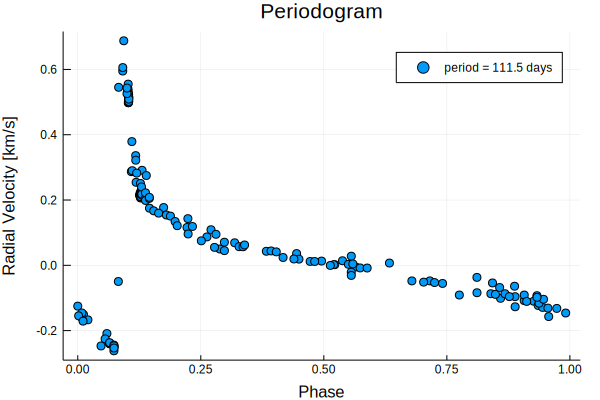

In [22]:
phase = []
period = FIND_P(time, RV)
for time_step in time
    calculated_phase = (time_step - minimum(time)) / period
    effective_phase = calculated_phase - floor(calculated_phase)
    push!(phase, effective_phase)
end

point_distances = []
        
for index = range(1, stop = length(time) - 1)
    point_distance = sqrt((RV[index+1] - RV[index])^2 + (phase[index+1] - phase[index])^2)
    push!(point_distances, point_distance)
end


plot(phase, RV, seriestype=:scatter, label="period = 111.5 days", title="Periodogram", 
    xlabel="Phase", ylabel="Radial Velocity [km/s]")

In [23]:
# Find h, c, and V0 given P, e, and t_p

# Isolate the values for time, radial velocity, and radial velocity error
time = mystery_planet01[:,1]
RV = mystery_planet01[:,2]
error = mystery_planet01[:,3]

function FIND_X2_hcV0(e, P, t_p)
    # Find... mean anomaly (M) > eccentric anomaly (E) > true anomaly (f) 
    M = (2 * pi./ P) * (time.- t_p)
    E = FIND_E.(M, e)
    f = 2 * atan.(((1 + e)/(1 - e))^(1/2) * tan.(E./2))
    
    # Find the derivatives of these with respect to h, c, and V0
    matrix = zeros(3,3)
    vector = zeros(3)
    coefficient = 1/(error.^2)
    
    # dX2 / dh
    matrix[1,1] = sum(coefficient * cos.(f).^2)
    matrix[1,2] = sum(coefficient * cos.(f) * sin.(f))
    matrix[1,3] = sum(coefficient * cos.(f))
    
    # dX2 / dc
    matrix[2,1] = matrix[1,2]
    matrix[2,2] = sum(coefficient * sin.(f).^2)
    matrix[2,3] = sum(coefficient * sin.(f))
    
    # dX2 / dV0
    matrix[3,1] = matrix[1,3]
    matrix[3,2] = matrix[2,3]
    matrix[3,3] = sum(coefficient)
    
    # Creating the divisor
    vector[1] = sum(coefficient * RV.* cos.(f))
    vector[2] = sum(coefficient * RV.* sin.(f))
    vector[3] = sum(coefficient * RV)
    
    # Identifying the variables h, c, and V0
    h, c, V0 = matrix \ vector
    
    # Find Vrad and Chi-squared
    Vrad = h.* cos.(f).+ c.* sin.(f).+ V0
    X2 = sum(coefficient * (RV.- Vrad).^2)
    
    # Return desired values
    return X2, h, c, V0
    
end

FIND_X2_hcV0 (generic function with 1 method)

In [10]:
# Use the function above (FIND_X2_hcV0) to find best values

function MINIMIZE_X2_hcV0(e, P, t_p)
    # Feed in a grid of values for P, e, and t_p and find the minimum X2
    # Starting values
    minimum_X2 = 1e7 ; I = -1 ; J = -1 ; K = -1
    
    for i = 1:length(e)
        for j = 1:length(P)
            for k = 1:length(t_p)
                println(e[i])
                println(P[j])
                println(t_p[k])
                println(FIND_X2_hcV0(e[i],P[j],t_p[k]))
                
                # If the new X2 is smaller than the previous one, make in the new minimum_X2
                if minimum_X2 > FIND_X2_hcV0(e[i],P[j],t_p[k])[1]
                    minimum_X2 = FIND_X2_hcV0(e[i],P[j],t_p[k])[1]
                    
                    I = i
                    J = j
                    K = k
                end
            end
        end
    end
    
    # Return minimized X2, as well as the associated values for h, c, and v0
    # Return the final e, P, and t_p values that minimized X2
    return(FIND_X2_hcV0(e[I],P[J],t_p[K])[1], FIND_X2_hcV0(e[I],P[J],t_p[K])[2], 
        FIND_X2_hcV0(e[I],P[J],t_p[K])[3], FIND_X2_hcV0(e[I],P[J],t_p[K])[4], 
        e[I], P[J], t_p[K])
    
end

MINIMIZE_X2_hcV0 (generic function with 1 method)

In [26]:
# Use period found in the periodogram and a grid of e, P, and t_p values to find the minimum X2

# We know from the periodogram that the planet has a high eccentricity
e = range(0.901, 0.999, length = 50)
P = range(0.9 * period, stop = 1.1 * period, length = 100)
t_p = range(0, stop = period, length = 200)

# Plug it in!
X2, h, c, V0, e, P, t_p = MINIMIZE_X2_hcV0(e, P, t_p)

0.901
100.36036434234234
0.0
(4074.747838513702, -0.052545534820974585, -2.9134869533926935, 0.10420246017416226)
0.901
100.36036434234234
0.5603593765624921
(8241.541067079857, -0.0013427173405577077, -4.110370818620423, 0.21701628107297916)
0.901
100.36036434234234
1.1207187531249843
(24906.52210050684, 0.2083135676539575, -7.045881854583462, 0.5739275569184408)
0.901
100.36036434234234
1.6810781296874764
(239886.7511915571, 3.1761512518242974, -22.25178106442702, 4.169528305881839)
0.901
100.36036434234234
2.2414375062499685
(4.239867349733809e7, 346.8723478169964, -361.3047678472308, 336.1151840092074)
0.901
100.36036434234234
2.8017968828124604
(41588.62728480869, 0.4404363703050257, -9.508098284997622, 0.8652768473392308)
0.901
100.36036434234234
3.3621562593749528
(8126.024069155574, 0.0039645373029171364, -4.03074993355729, 0.13204471732862194)
0.901
100.36036434234234
3.9225156359374447
(8113.6682483435525, 0.005809526007181588, -3.662062021544788, 0.12186581663277067)
0.901
1

100.36036434234234
36.42335947656199
(700.0340548935922, -0.09450500502276438, 1.0142558817421488, -0.07306623854734537)
0.901
100.36036434234234
36.98371885312448
(684.1744598314111, -0.09491130777696406, 0.9950751252482143, -0.0793232937366212)
0.901
100.36036434234234
37.544078229686974
(665.0211858340322, -0.09537218448543042, 0.9608131962086279, -0.08439642429753239)
0.901
100.36036434234234
38.10443760624946
(655.3095326102077, -0.09592565557378854, 0.9468647967865941, -0.0901688720047908)
0.901
100.36036434234234
38.66479698281196
(635.5167571475313, -0.09688965300967588, 0.9300083950924135, -0.09359530015493207)
0.901
100.36036434234234
39.22515635937445
(660.3120204406606, -0.0972022516554834, 0.9247495890788008, -0.08960460713679683)
0.901
100.36036434234234
39.78551573593694
(657.1902186575375, -0.09674794950604076, 0.8704878980070027, -0.08815451842733216)
0.901
100.36036434234234
40.345875112499435
(608.3576157534721, -0.0972561610086753, 0.8067331204512996, -0.08948563958

(368.60590882253797, -0.1090989970581048, -0.6103300729970514, -0.08919410749838194)
0.901
100.36036434234234
75.08815645937395
(344.0559578816151, -0.10760546964408715, -0.5859222675550618, -0.09322615954523875)
0.901
100.36036434234234
75.64851583593644
(358.2676234803381, -0.10521655001365576, -0.5824606333441773, -0.09294682189079859)
0.901
100.36036434234234
76.20887521249892
(380.4495716048853, -0.10369083185219416, -0.6050668022672102, -0.09121950831493442)
0.901
100.36036434234234
76.76923458906143
(402.4118154045371, -0.10244941376713884, -0.6258307587349358, -0.08975050230843686)
0.901
100.36036434234234
77.32959396562391
(452.9649007929511, -0.10126799585380232, -0.67599036847153, -0.08809594844778032)
0.901
100.36036434234234
77.8899533421864
(493.48626447166333, -0.10131530891597898, -0.7365426828866426, -0.08839888525210987)
0.901
100.36036434234234
78.4503127187489
(441.02303216959285, -0.10246716685032867, -0.76488803343371, -0.09772819676823483)
0.901
100.3603643423423

0.901
100.36036434234234
110.95115655937344
(19130.130546882487, 0.1426571142695903, -6.30416807939505, 0.22413846034794355)
0.901
100.36036434234234
111.51151593593593
(62969.66532382953, 0.6953633082718607, -11.59586325899313, 0.8290982905766906)
0.901
100.5856401321119
0.0
(571.0173898368922, -0.10718395095110513, -0.6968100618497638, -0.09900211007825795)
0.901
100.5856401321119
0.5603593765624921
(662.4356764323755, -0.10517564906894482, -0.7576103006189291, -0.09283320329041707)
0.901
100.5856401321119
1.1207187531249843
(610.2398176815299, -0.10794090894881943, -0.7743438501881389, -0.09434927301452123)
0.901
100.5856401321119
1.6810781296874764
(464.1315018338839, -0.10893703946436907, -0.7245251731037208, -0.11064201673044778)
0.901
100.5856401321119
2.2414375062499685
(443.3083050774566, -0.10671173714822056, -0.7111619162656998, -0.11557407776795081)
0.901
100.5856401321119
2.8017968828124604
(415.6377891141266, -0.1045011945528275, -0.6971405336728634, -0.11595930986115618)

(49287.58986393026, 0.5205781028320168, -9.538754429405946, 0.4550625169204178)
0.901
100.5856401321119
37.544078229686974
(62866.663910506, 0.6842722829793417, -11.084961912050625, 0.5799568695942612)
0.901
100.5856401321119
38.10443760624946
(64288.86638326247, 0.6935815288503169, -11.180020982457778, 0.5722239664835441)
0.901
100.5856401321119
38.66479698281196
(116629.65853305381, 1.3069242533356085, -14.566205714306918, 1.1242894299421733)
0.901
100.5856401321119
39.22515635937445
(1.6932810052200633e6, 20.13367156947702, 55.39830480706257, 19.1462307799845)
0.901
100.5856401321119
39.78551573593694
(41357.49135307029, 0.37858314053128955, 8.408857906735328, 0.38684842560463645)
0.901
100.5856401321119
40.345875112499435
(12703.599931461744, 0.03957168499611159, 4.506320892243225, 0.04764439276517497)
0.901
100.5856401321119
40.90623448906192
(6610.051981140904, -0.03171700738527257, 3.131519750985182, -0.02747978515377055)
0.901
100.5856401321119
41.46659386562442
(5452.153119810

(494.3039897459095, -0.11094137619500623, 0.5280376286164665, -0.09785282304605253)
0.901
100.5856401321119
75.08815645937395
(499.0712311403546, -0.11344266571342455, 0.5505325037875101, -0.0791715733386497)
0.901
100.5856401321119
75.64851583593644
(518.6533215499454, -0.11034330707038029, 0.5261554560921642, -0.0670993455045888)
0.901
100.5856401321119
76.20887521249892
(499.89735458099216, -0.1102791461944032, 0.5043502474263333, -0.06667515004855729)
0.901
100.5856401321119
76.76923458906143
(458.90640665080383, -0.11343616083849097, 0.4963051574972195, -0.06638983173179286)
0.901
100.5856401321119
77.32959396562391
(474.5899902817538, -0.11545100757373389, 0.5282402321048137, -0.05587545347999463)
0.901
100.5856401321119
77.8899533421864
(490.6968604780834, -0.11395786828602428, 0.5305804543356193, -0.03724638202606682)
0.901
100.5856401321119
78.4503127187489
(454.17819620202425, -0.11183667050294913, 0.4929948647993177, -0.03375592065419225)
0.901
100.5856401321119
79.010672095

0.901
100.81091592188147
7.284671895312398
(1171.4915250945933, -0.08990156117536359, 1.3555823132594964, -0.01006277730614798)
0.901
100.81091592188147
7.845031271874889
(1128.6232640446324, -0.090262793197644, 1.3358398099239908, -0.01992727908153849)
0.901
100.81091592188147
8.405390648437383
(1073.354570026677, -0.0909021212695343, 1.2957381928940581, -0.02951172660472093)
0.901
100.81091592188147
8.965750024999874
(1049.2857926643524, -0.09130787980603775, 1.2746150364178255, -0.038354653646607936)
0.901
100.81091592188147
9.526109401562366
(914.8002647630966, -0.09324648476697266, 1.1898943383365683, -0.043724023187107774)
0.901
100.81091592188147
10.086468778124859
(896.0147154743394, -0.0933780640458042, 1.1872122811808203, -0.04261476031400992)
0.901
100.81091592188147
10.64682815468735
(921.0720936096828, -0.0926642987490773, 1.1882969819577405, -0.047404945065223345)
0.901
100.81091592188147
11.207187531249842
(867.0208809895107, -0.09321122404013765, 1.1212343245114786, -0.

(6897.499039284071, -0.0355585824632136, -2.6181296628085478, 0.10048649823717472)
0.901
100.81091592188147
45.38910950156186
(5871.827627447259, -0.04768154838103435, -2.3591910911189995, 0.10561945823867921)
0.901
100.81091592188147
45.94946887812436
(7396.46782327171, -0.030857182495143003, -2.6597720719431903, 0.1569810300238217)
0.901
100.81091592188147
46.509828254686845
(8716.501637590418, -0.016266332263199547, -2.880024544588861, 0.2087379885881835)
0.901
100.81091592188147
47.07018763124934
(10923.734567027062, 0.008511798838390818, -3.210414599244776, 0.28346648024375404)
0.901
100.81091592188147
47.63054700781183
(22742.90057676685, 0.14918480586898536, -4.698040802620259, 0.5592749416631234)
0.901
100.81091592188147
48.19090638437432
(171017.709574898, 2.1166722903536894, -13.517571674850874, 3.1421986877766828)
0.901
100.81091592188147
48.75126576093682
(213670.86068359276, 2.4475329732622066, 14.017174197128139, 0.7827645375251955)
0.901
100.81091592188147
49.31162513749

(214920.93415022173, 2.5116319267401317, 19.532838509436402, 2.1001486683766744)
0.901
100.81091592188147
84.05390648437381
(755577.6330003784, 8.243076581397371, 34.52038862821083, 7.127849251255394)
0.901
100.81091592188147
84.61426586093631
(108530.79484052908, 1.2921352732989644, -14.256298559257646, 1.2748948808209153)
0.901
100.81091592188147
85.1746252374988
(9441.289520163766, 0.025802499631491158, -4.406559474024664, 0.05869062007179283)
0.901
100.81091592188147
85.73498461406129
(10706.324217739357, 0.04208668390274664, -4.394755762597673, 0.07290250366050526)
0.901
100.81091592188147
86.29534399062379
(32246.885327653155, 0.3181702712568959, -7.484800784295154, 0.36165614919997563)
0.901
100.81091592188147
86.85570336718628
(347246.8821269486, 4.356942833503905, -25.227875847981636, 4.20691931744316)
0.901
100.81091592188147
87.41606274374877
(1.8941340047438622e8, -509.0586799320504, 367.6365904472192, -460.40368432709136)
0.901
100.81091592188147
87.97642212031127
(247516.

0.901
101.03619171165104
11.207187531249842
(1326.4872541051286, -0.10277164012279019, -0.8944103619166045, -0.03335498320195587)
0.901
101.03619171165104
11.767546907812335
(1365.7338416415766, -0.10013922281625966, -0.8887955597639214, -0.04358210755610166)
0.901
101.03619171165104
12.327906284374826
(1523.6121615937027, -0.09690450614450839, -0.947900386894083, -0.03616988370065195)
0.901
101.03619171165104
12.88826566093732
(1549.3147183792516, -0.09645153760474763, -0.9727916356931793, -0.026974724802820645)
0.901
101.03619171165104
13.448625037499811
(1589.5047591266482, -0.09593064089879724, -1.003018442774968, -0.022938036263585385)
0.901
101.03619171165104
14.008984414062303
(1798.8285461352307, -0.09436196307138263, -1.1003994842750473, -0.0170852959188871)
0.901
101.03619171165104
14.569343790624796
(1939.7360268455084, -0.09374485435273475, -1.1614832947663178, -0.027127851487202537)
0.901
101.03619171165104
15.129703167187287
(2395.6460768615634, -0.0880549447495753, -1.28

(1988.5962624765639, -0.07709057404440417, -2.074470793809949, -0.08360812120226012)
0.901
101.03619171165104
51.55306264374928
(1923.5740825369883, -0.0778138277061832, -2.0394361167400366, -0.07010197690727182)
0.901
101.03619171165104
52.113422020311766
(2576.2965435116216, -0.06948136815452194, -2.3863831374599886, -0.05799290388667603)
0.901
101.03619171165104
52.67378139687426
(4089.4315586382068, -0.050550413423025346, -3.044684437061717, -0.03688684042311799)
0.901
101.03619171165104
53.23414077343675
(7755.339984922167, -0.005091904604688969, -4.210799704600825, 0.011952297023393298)
0.901
101.03619171165104
53.794500149999244
(19775.207465685726, 0.1440874937688104, -6.718786435996788, 0.16556545638246611)
0.901
101.03619171165104
54.35485952656174
(78155.31382048641, 0.8816462534535079, -13.684640828640063, 0.879553076119189)
0.901
101.03619171165104
54.91521890312423
(118855.4807723941, 1.3380335938689742, -17.21970260023333, 1.2052820524897063)
0.901
101.03619171165104
55.

(4059.664871070949, -0.06864050604759353, -1.8240151879213007, 0.0007243810131562695)
0.901
101.26146750142061
15.129703167187287
(4434.772348212064, -0.06526950493366962, -1.9728270287105945, 0.009618662558758881)
0.901
101.26146750142061
15.690062543749779
(4690.719948620931, -0.06420582021371196, -2.086505824702497, -0.0021554478107638254)
0.901
101.26146750142061
16.25042192031227
(6061.141024233452, -0.04856974204016012, -2.3102604899409775, -0.0030849304142978994)
0.901
101.26146750142061
16.810781296874765
(10095.18516620217, -0.0024355133928227702, -3.052711643370958, 0.055503333856301795)
0.901
101.26146750142061
17.371140673437257
(20264.737595469323, 0.11720561033902015, -4.509900369460088, 0.20185359126675623)
0.901
101.26146750142061
17.931500049999748
(22814.049976388305, 0.14756869792450739, -4.971347973253082, 0.241607095347043)
0.901
101.26146750142061
18.49185942656224
(20766.158330914852, 0.12305432293115574, -4.558438918057522, 0.21640709860883006)
0.901
101.2614675

(2446.026798756804, -0.07236610067673259, -2.2481983431920054, -0.1078983343064168)
0.901
101.26146750142061
52.113422020311766
(3648.6436067522345, -0.05676870375730959, -2.778835167021585, -0.1032963924850536)
0.901
101.26146750142061
52.67378139687426
(6320.949880096894, -0.023403906877170384, -3.7346229078446207, -0.08713771506641742)
0.901
101.26146750142061
53.23414077343675
(14099.585120024189, 0.07216628178309743, -5.651851556729665, -0.026545036531474307)
0.901
101.26146750142061
53.794500149999244
(57071.389264344165, 0.5956477331030303, -11.41537968657612, 0.3814771480007418)
0.901
101.26146750142061
54.35485952656174
(1.8990187487068279e9, -5972.617222934601, -1153.2469483937682, -5714.50600203896)
0.901
101.26146750142061
54.91521890312423
(57165.71153226611, 0.5700755028102981, 11.11396947168548, 0.7131802467861189)
0.901
101.26146750142061
55.47557827968672
(14948.495564427327, 0.07126402273832762, 5.549201972782389, 0.14956280413654646)
0.901
101.26146750142061
56.03593

(407.5975624900035, -0.10136601571404492, -0.4765922367700562, 0.01324719753495872)
0.901
101.48674329119018
16.810781296874765
(427.9571919003405, -0.10166388553582552, -0.512572950618842, 0.01819016530989808)
0.901
101.48674329119018
17.371140673437257
(438.92133157360894, -0.10297525932820051, -0.5582034363999595, 0.01801958651639437)
0.901
101.48674329119018
17.931500049999748
(468.8674383787466, -0.10232328594575085, -0.5729005807321658, 0.01184174004925373)
0.901
101.48674329119018
18.49185942656224
(483.429061848976, -0.1019470702822474, -0.6001202199681493, 0.008206885749923825)
0.901
101.48674329119018
19.05221880312473
(512.4039580404266, -0.10021600834590794, -0.6104445155645705, 0.006642468391179958)
0.901
101.48674329119018
19.612578179687226
(526.8724254233799, -0.09908573595681144, -0.6279103663431224, 0.011068529199023064)
0.901
101.48674329119018
20.172937556249718
(555.3737059644587, -0.0981092632228075, -0.6709888781540505, 0.017978301752564627)
0.901
101.48674329119

(1019.0135225154627, -0.10877561744669664, -1.0438497486057692, -0.18170635574656718)
0.901
101.48674329119018
56.03593765624921
(1172.0613302727666, -0.09900061614843408, -1.0880304741176836, -0.18083334789367836)
0.901
101.48674329119018
56.596297032811705
(1368.5473836177475, -0.09358549716190372, -1.1877206243708753, -0.18032376983615478)
0.901
101.48674329119018
57.15665640937419
(1678.468731341548, -0.08864554674844222, -1.3437076207872285, -0.18580827679111134)
0.901
101.48674329119018
57.71701578593669
(1478.814783731481, -0.09129708550094356, -1.3713293557867463, -0.19812638486431947)
0.901
101.48674329119018
58.27737516249918
(1178.8681722184356, -0.09375496110559063, -1.2443978309137251, -0.19097012498345703)
0.901
101.48674329119018
58.83773453906167
(847.3460093747758, -0.09740344763068232, -1.1038063988750402, -0.17609735469982743)
0.901
101.48674329119018
59.398093915624166
(644.989002691336, -0.09920376612226356, -0.9255530611289623, -0.14815296093083774)
0.901
101.4867

(1025.314520563942, -0.08806022717139933, -1.498669988343931, -0.15991344658676268)
0.901
101.71201908095975
14.569343790624796
(1287.2457125589096, -0.08400979238325447, -1.7196313024828296, -0.1656225048783474)
0.901
101.71201908095975
15.129703167187287
(1701.7244320016093, -0.07810587094805967, -2.0157673287982574, -0.1728262761067865)
0.901
101.71201908095975
15.690062543749779
(2413.061403535418, -0.06845060043663223, -2.4307436595117897, -0.18181884537589021)
0.901
101.71201908095975
16.25042192031227
(3776.946879537836, -0.050520440904191215, -3.0572340981279886, -0.19251532140994346)
0.901
101.71201908095975
16.810781296874765
(6891.465450726986, -0.010527908076591926, -4.12113140278071, -0.20203569223694973)
0.901
101.71201908095975
17.371140673437257
(16664.02824020757, 0.11263996293638827, -6.349503523043834, -0.18516185737421623)
0.901
101.71201908095975
17.931500049999748
(84091.70427342717, 0.9510939213364284, -14.05527521365304, 0.26474263808404175)
0.901
101.7120190809

(428.64957585257963, -0.09945579361265204, 0.4230869278450458, -0.029002145236396597)
0.901
101.71201908095975
53.23414077343675
(413.64918410921473, -0.10000853196677809, 0.38724712800022176, -0.030557110607533633)
0.901
101.71201908095975
53.794500149999244
(399.29763017064363, -0.10077541068107389, 0.3516438928036675, -0.03161988024992869)
0.901
101.71201908095975
54.35485952656174
(386.14859523811, -0.10189070831120363, 0.3178985919903421, -0.03220475436415897)
0.901
101.71201908095975
54.91521890312423
(378.6979826922183, -0.10351003288955138, 0.29400800514911657, -0.03268655872435839)
0.901
101.71201908095975
55.47557827968672
(367.5225815388658, -0.10602221957814095, 0.2706700527489427, -0.032141284970169805)
0.901
101.71201908095975
56.03593765624921
(356.92709556565444, -0.10985033147186633, 0.2517053214889747, -0.02819560951660107)
0.901
101.71201908095975
56.596297032811705
(374.52982996437385, -0.11438699049978236, 0.3051898672268423, -0.02493839659513241)
0.901
101.7120190

0.901
101.71201908095975
89.65750024999873
(21815.883550771403, 0.13729065829190593, -4.701926546615745, 0.16947296024612032)
0.901
101.71201908095975
90.21785962656124
(41808.186512953616, 0.37566494963003777, -6.3950494978459576, 0.38291024706775156)
0.901
101.71201908095975
90.77821900312372
(366452.36010977766, 4.326795394937812, -19.681559590798944, 4.0061169796804945)
0.901
101.71201908095975
91.33857837968621
(7.536751904283085e8, -941.3534165847561, 658.5823896218551, -820.5464102224558)
0.901
101.71201908095975
91.89893775624871
(785800.1002281541, 8.131734847735789, -27.97958896613648, 6.930759006616965)
0.901
101.71201908095975
92.4592971328112
(685260.4574954313, 8.892299990247066, 28.469508978269257, 8.125658742659446)
0.901
101.71201908095975
93.01965650937369
(135466.2176629954, 1.6772073815882456, 12.617763620953216, 1.4833674262890828)
0.901
101.71201908095975
93.58001588593619
(47107.57717439272, 0.5258282325833085, 7.49396588132846, 0.40174855294611955)
0.901
101.712

(636.0604175997246, -0.0971761784979919, 0.7082075680015831, 0.011973663133394858)
0.901
101.9372948707293
15.690062543749779
(607.9861293827248, -0.09751122551468237, 0.6755759651329059, 0.006011325290212631)
0.901
101.9372948707293
16.25042192031227
(581.3615904301068, -0.09774933464247766, 0.6355437692735998, 0.0002455592120756417)
0.901
101.9372948707293
16.810781296874765
(544.0413670793781, -0.09825438865939556, 0.5816439980398252, -0.005351692967367082)
0.901
101.9372948707293
17.371140673437257
(518.3567928761927, -0.09887818327105215, 0.5399745951123447, -0.009884018344786515)
0.901
101.9372948707293
17.931500049999748
(507.2302268898563, -0.09952082853485078, 0.5149652239454254, -0.013468019815558353)
0.901
101.9372948707293
18.49185942656224
(476.5013929154363, -0.10074819760701738, 0.4816905670276749, -0.01503996084570811)
0.901
101.9372948707293
19.05221880312473
(460.32658022419395, -0.10129068919033088, 0.45349738898270864, -0.013531372743219139)
0.901
101.9372948707293


(4686.072562096145, -0.04937475677729288, 2.2267224068458216, -0.10143964184981985)
0.901
101.9372948707293
56.596297032811705
(4222.019978820976, -0.05650314002973929, 2.1497490450683996, -0.09766381687483708)
0.901
101.9372948707293
57.15665640937419
(5559.26049151225, -0.03763750899572795, 2.5405983930423788, -0.0530891332391406)
0.901
101.9372948707293
57.71701578593669
(20972.351662584213, 0.1805272320102102, 5.0465622318440815, 0.13768536489001917)
0.901
101.9372948707293
58.27737516249918
(1.2376377382283324e8, -491.8871714609214, -275.75503775615607, -417.8491248309526)
0.901
101.9372948707293
58.83773453906167
(2.3375664448235533e6, 22.260937839175188, -44.03087364247265, 19.67188902297862)
0.901
101.9372948707293
59.398093915624166
(1.3506739580349568e6, 14.337447797232532, -34.8835818096341, 13.019169313548003)
0.901
101.9372948707293
59.958453292186654
(1.1760160157220645e6, 13.535475659415589, 34.62160783023041, 11.18501310815673)
0.901
101.9372948707293
60.51881266874915


0.901
101.9372948707293
94.70073463906117
(8467.243827312832, -0.00857338037980062, 3.9587419117897387, 0.1434271628650063)
0.901
101.9372948707293
95.26109401562366
(4905.264601025336, -0.04986542621406569, 2.894008167309319, 0.0626299962651438)
0.901
101.9372948707293
95.82145339218616
(3325.602331842693, -0.06829760629854305, 2.3025179376776963, 0.022861055590777408)
0.901
101.9372948707293
96.38181276874865
(2740.0501950183652, -0.07586723861120231, 2.100633248508436, 0.012639113478692988)
0.901
101.9372948707293
96.94217214531113
(2671.0183619374193, -0.07683006966133465, 2.000649780379156, 0.014683820759881408)
0.901
101.9372948707293
97.50253152187364
(2313.5630024920406, -0.08173080022727956, 1.8994236713339971, 0.020401954030479966)
0.901
101.9372948707293
98.06289089843612
(2260.28975058115, -0.08186807735341074, 1.7999318215201574, 0.029672722229433436)
0.901
101.9372948707293
98.62325027499861
(2132.468627009458, -0.08320413230465139, 1.7394751016958496, 0.03586191283026124

(2171.395787613063, -0.07713755375293387, -1.9205467295426932, 0.06341267305828077)
0.901
102.16257066049887
33.061203217187035
(3146.2178110093214, -0.06483353772169684, -2.382211926808536, 0.1089030191590592)
0.901
102.16257066049887
33.62156259374953
(5043.460538290775, -0.0410168708982457, -3.0768208720469374, 0.18377457272455305)
0.901
102.16257066049887
34.18192197031202
(6707.146091134198, -0.019662071740192716, -3.582882033454983, 0.25672516683836905)
0.901
102.16257066049887
34.74228134687451
(6424.152242207082, -0.02295877895055219, -3.479246393771394, 0.2753102258533371)
0.901
102.16257066049887
35.302640723437
(4427.56455025088, -0.048842322592078886, -2.84674125248328, 0.2314161167169122)
0.901
102.16257066049887
35.863000099999496
(3872.36802912461, -0.057627416490800776, -2.726802969499926, 0.22012146483179856)
0.901
102.16257066049887
36.42335947656199
(2849.21716238267, -0.0719325686620632, -2.2704720861682888, 0.1432355339808027)
0.901
102.16257066049887
36.9837188531

(492.7097393736104, -0.12158735638879627, -0.6427377773660591, -0.13836757998564866)
0.901
102.16257066049887
73.96743770624896
(506.1528718547108, -0.11109853445011518, -0.6444656938682445, -0.13515209452513516)
0.901
102.16257066049887
74.52779708281145
(580.2010850299857, -0.1059189088712391, -0.7064862497042067, -0.13410385758172144)
0.901
102.16257066049887
75.08815645937395
(677.3850275387525, -0.10313702151263787, -0.788759989402962, -0.13487449480950067)
0.901
102.16257066049887
75.64851583593644
(681.4167791657611, -0.10304213612475666, -0.8632900809477292, -0.14245293439369444)
0.901
102.16257066049887
76.20887521249892
(648.628404037453, -0.10150741939758887, -0.8987217295232559, -0.15367992759445445)
0.901
102.16257066049887
76.76923458906143
(604.6543823037701, -0.10046422345982486, -0.9346093089953564, -0.16052822028255456)
0.901
102.16257066049887
77.32959396562391
(644.6097871670274, -0.09759079471448326, -0.9812642225529994, -0.1646544380228121)
0.901
102.1625706604988

(592.6397855724124, -0.10275039155533189, 0.5021260507049491, 0.018585881940139916)
0.901
102.38784645026844
23.53509381562467
(548.2895819726409, -0.10335110087697703, 0.46093865515845517, 0.011938208896712807)
0.901
102.38784645026844
24.09545319218716
(518.8990531753872, -0.10438725672155735, 0.4287410517342468, 0.007106206226361871)
0.901
102.38784645026844
24.655812568749653
(477.2070878045091, -0.10712721761481757, 0.39102282590045917, 0.004789484169781339)
0.901
102.38784645026844
25.216171945312144
(657.1179914506107, -0.10733382245671262, 0.6211932425929562, 0.023405076843544186)
0.901
102.38784645026844
25.77653132187464
(294.1940820853027, -0.11051797879961196, -0.3473056852787059, -0.025908444352624425)
0.901
102.38784645026844
26.33689069843713
(281.0314096597683, -0.10834429636044748, -0.2856664518989404, -0.026445331942531743)
0.901
102.38784645026844
26.897250074999622
(289.3998051757659, -0.10594856005335618, -0.3054814797799536, -0.02980028615642769)
0.901
102.3878464

(10406.094553997104, 0.050013268486923494, 3.1951113016363597, -0.10171888464850887)
0.901
102.38784645026844
91.33857837968621
(14325.195004566143, 0.11006627067258662, 3.6446774041863206, -0.05816252545046261)
0.901
102.38784645026844
91.89893775624871
(26748.10596468884, 0.2806911995921213, 4.6523995162611955, 0.035853064450139326)
0.901
102.38784645026844
92.4592971328112
(26386.693043973657, 0.2183528561271069, -5.695175448991987, 0.12374912160885786)
0.901
102.38784645026844
93.01965650937369
(748.8424382541094, -0.12778727747864, -0.8890037755915239, -0.1670696755302726)
0.901
102.38784645026844
93.58001588593619
(632.9286086967674, -0.11190541939871873, -0.7703940843180511, -0.1617584787921806)
0.901
102.38784645026844
94.14037526249868
(725.9273471907202, -0.10440831234194192, -0.8351047665716126, -0.16086798430473817)
0.901
102.38784645026844
94.70073463906117
(885.3848202952581, -0.09978001922235673, -0.9437833733346664, -0.1625954255153639)
0.901
102.38784645026844
95.26109

0.901
102.61312224003801
44.82875012499937
(8421.347324201863, -0.011504595631749773, 3.9339090098513063, 0.44560882399622115)
0.901
102.61312224003801
45.38910950156186
(6782.664401156316, -0.029731736730514047, 3.3436787535090007, 0.3805194116616256)
0.901
102.61312224003801
45.94946887812436
(4012.6622181359057, -0.061243513967427526, 2.4865727442313452, 0.250024792428378)
0.901
102.61312224003801
46.509828254686845
(2717.624791795302, -0.0755227600484961, 2.0032784201978613, 0.1769757180960349)
0.901
102.61312224003801
47.07018763124934
(2368.5658133780826, -0.07908733437899051, 1.8686895850184893, 0.14936145416645177)
0.901
102.61312224003801
47.63054700781183
(1906.327745635216, -0.08394157450196786, 1.631270607526227, 0.1146771885956599)
0.901
102.61312224003801
48.19090638437432
(1481.020403637213, -0.08847960591869859, 1.385211818627623, 0.0831131108456769)
0.901
102.61312224003801
48.75126576093682
(1297.4739007456742, -0.0904791561563037, 1.2709459460256116, 0.06546515845492

0.901
102.61312224003801
84.61426586093631
(1506.2781376761327, -0.0825915608779177, -1.8659157684545116, 0.025394930345012792)
0.901
102.61312224003801
85.1746252374988
(1453.6592416882818, -0.08299307828203369, -1.8253342599445102, 0.03521002350431829)
0.901
102.61312224003801
85.73498461406129
(1450.5327826623707, -0.08280294215567935, -1.8488903297217387, 0.0473058825441457)
0.901
102.61312224003801
86.29534399062379
(1535.6358960476796, -0.0815232829874823, -1.9184563338968228, 0.06249045212123722)
0.901
102.61312224003801
86.85570336718628
(1602.0219911994382, -0.08054705274463261, -1.9629911494432803, 0.0774951587548852)
0.901
102.61312224003801
87.41606274374877
(2198.412769984108, -0.07275505565342873, -2.3189977900058754, 0.11458931036594536)
0.901
102.61312224003801
87.97642212031127
(3577.5076102840103, -0.055033348177893904, -2.972342812664062, 0.18244369597917975)
0.901
102.61312224003801
88.53678149687376
(7013.9595420929845, -0.011223514968276975, -4.140964079194364, 0.

(286.62089338598537, -0.10278503164526605, -0.41836057808348015, -0.06234333103062356)
0.901
102.83839802980758
28.578328204687097
(290.16569655896296, -0.10135192843275671, -0.4430138441069142, -0.060476513674022604)
0.901
102.83839802980758
29.13868758124959
(293.21941595403325, -0.10040049937402927, -0.4701495433364197, -0.058590943126203075)
0.901
102.83839802980758
29.699046957812083
(297.19809527644526, -0.09970311455060538, -0.4995519705030774, -0.05666048616030532)
0.901
102.83839802980758
30.259406334374574
(302.8877022453515, -0.09916067388809219, -0.5314243722450082, -0.054612831544916564)
0.901
102.83839802980758
30.819765710937066
(310.9573443023175, -0.0987320596953692, -0.5658684418258693, -0.05235279661204017)
0.901
102.83839802980758
31.380125087499557
(320.87190623640487, -0.09844291405939988, -0.6006466580184002, -0.04969929598983259)
0.901
102.83839802980758
31.940484464062052
(324.0803832695626, -0.0984431673433904, -0.6188800654058937, -0.046197331884403614)
0.901

(1281.1687119709952, -0.08714939868499458, 1.317611098454271, -0.08166965306177681)
0.901
102.83839802980758
98.06289089843612
(1318.7165095797675, -0.08812974229371637, 1.3412394047686795, -0.07786989029882628)
0.901
102.83839802980758
98.62325027499861
(1299.2529751346501, -0.08946301810238096, 1.300950139949165, -0.07704734880073161)
0.901
102.83839802980758
99.1836096515611
(1542.0517235717205, -0.08646541666782626, 1.440109522674855, -0.0665914776017465)
0.901
102.83839802980758
99.7439690281236
(2354.946287102741, -0.07208401039286048, 1.6604469328765008, -0.043962024171466135)
0.901
102.83839802980758
100.30432840468609
(2440.3793675265997, -0.07202753962866976, 1.6312725822177943, -0.04672022228480854)
0.901
102.83839802980758
100.86468778124858
(2715.40552541501, -0.07648217041690535, 1.8737500750633131, -0.029587465245051705)
0.901
102.83839802980758
101.42504715781108
(9905.769371844674, -0.007832647602186596, -3.8911374127954446, -0.37180148398204516)
0.901
102.838398029807

(604.7366119979192, -0.09452310773987174, -1.2730216730153272, -0.06273966711551049)
0.901
103.06367381957715
25.77653132187464
(688.7483955335381, -0.09245205502090158, -1.275837780297844, -0.05944691339121506)
0.901
103.06367381957715
26.33689069843713
(708.5432767942984, -0.09188981495697149, -1.3079122265362302, -0.05206860152568524)
0.901
103.06367381957715
26.897250074999622
(699.4948840586512, -0.09224839806265922, -1.3249747808324897, -0.04603655085828838)
0.901
103.06367381957715
27.457609451562114
(618.840239654556, -0.09373538067222918, -1.3472471110324502, -0.05314959953820661)
0.901
103.06367381957715
28.017968828124605
(740.4713709934312, -0.09142168778130552, -1.3903134904689347, -0.05696217703209196)
0.901
103.06367381957715
28.578328204687097
(886.73762355913, -0.08878008273274578, -1.5447023099633297, -0.052007522463400194)
0.901
103.06367381957715
29.13868758124959
(1079.2423399553645, -0.08569864949905964, -1.7601466620193607, -0.044211309984594806)
0.901
103.063673

0.901
103.06367381957715
98.62325027499861
(1294.017014245145, -0.09400000397829343, 1.0449253534520673, 0.10677487058953428)
0.901
103.06367381957715
99.1836096515611
(1191.7420590876932, -0.09471957723428304, 0.9960617733841092, 0.09243573642892007)
0.901
103.06367381957715
99.7439690281236
(1165.9164257193308, -0.0948503705770172, 0.9886758564514103, 0.08362192964074673)
0.901
103.06367381957715
100.30432840468609
(1153.0063186270925, -0.09522493880690279, 0.9980447165826322, 0.07804447530322978)
0.901
103.06367381957715
100.86468778124858
(1155.8517833828032, -0.0962723309322377, 1.0527576987395983, 0.08416494789827539)
0.901
103.06367381957715
101.42504715781108
(1485.3516686260689, -0.09172508340711949, 1.212853678598778, 0.11145917236891002)
0.901
103.06367381957715
101.98540653437357
(1204.5071343273644, -0.09372844741204503, 1.0266746812271887, 0.08595693193832413)
0.901
103.06367381957715
102.54576591093605
(908.5107197775069, -0.09655902301701974, 0.8255705978218919, 0.05863

0.901
103.28894960934672
28.578328204687097
(376.5289778550167, -0.09693585627405892, -0.7928322619894416, -0.08270603882539102)
0.901
103.28894960934672
29.13868758124959
(394.8610329429415, -0.09625969301279673, -0.8496738193114156, -0.08057239559238497)
0.901
103.28894960934672
29.699046957812083
(420.4036794302479, -0.09556825174575989, -0.914213814139037, -0.07827624665892052)
0.901
103.28894960934672
30.259406334374574
(455.74657298493855, -0.0948195605482387, -0.9879217647804851, -0.07567673466841003)
0.901
103.28894960934672
30.819765710937066
(500.5071219118571, -0.09404132761100865, -1.0679452987890468, -0.0724295874567586)
0.901
103.28894960934672
31.380125087499557
(520.7629417590642, -0.09376699961473133, -1.112999989572926, -0.06717923913946047)
0.901
103.28894960934672
31.940484464062052
(535.8996451564141, -0.09358292741839266, -1.1225214745504597, -0.0604929437734265)
0.901
103.28894960934672
32.50084384062454
(616.9218910098524, -0.09256052593921772, -1.21670826434696

0.901
103.28894960934672
96.94217214531113
(521.8708751030713, -0.10106013338204257, 0.8192497996369784, -0.040809408572796545)
0.901
103.28894960934672
97.50253152187364
(452.2420119411447, -0.10238273276763177, 0.7637560550925726, -0.04664068650313067)
0.901
103.28894960934672
98.06289089843612
(407.1852815511937, -0.10408148880817442, 0.7275602312597595, -0.05251787987242195)
0.901
103.28894960934672
98.62325027499861
(340.19611776062794, -0.1073496010400781, 0.7093624233940258, -0.055933130279301996)
0.901
103.28894960934672
99.1836096515611
(349.7541714511307, -0.10847195560063191, 0.7410589496992341, -0.05036205361761716)
0.901
103.28894960934672
99.7439690281236
(353.1778914872291, -0.10972276596209382, 0.7261818359390851, -0.04961022718454565)
0.901
103.28894960934672
100.30432840468609
(320.0432708740661, -0.11502357132756656, 0.6931936461549425, -0.05322337032811147)
0.901
103.28894960934672
100.86468778124858
(353.4685182497695, -0.12888248170071223, 0.7764902720337871, -0.0

(811.2489660987189, -0.09631904435812429, 1.0896779760559285, -0.023036581822407604)
0.901
103.51422539911628
23.53509381562467
(748.761600028879, -0.09693176759011925, 1.048889158748145, -0.015660905915799325)
0.901
103.51422539911628
24.09545319218716
(675.4038924044156, -0.09691827214962392, 0.9499919569458793, -0.01777784923842574)
0.901
103.51422539911628
24.655812568749653
(522.5141621137927, -0.09912294843669875, 0.8405601350577313, -0.028446253784664744)
0.901
103.51422539911628
25.216171945312144
(416.861707278737, -0.10203230641883905, 0.7739403243840438, -0.03484884979752924)
0.901
103.51422539911628
25.77653132187464
(450.7108810053204, -0.10326952173574358, 0.7751284270907888, -0.02767292035192622)
0.901
103.51422539911628
26.33689069843713
(482.82255831398356, -0.10206644587506948, 0.7257809545443039, -0.026052577315477537)
0.901
103.51422539911628
26.897250074999622
(406.9826421406288, -0.1030935713215582, 0.6555430362262393, -0.032923234542496335)
0.901
103.514225399116

0.901
103.51422539911628
82.37282835468635
(4952.2454893723625, -0.04942849899111212, 3.4998418816938295, -0.08621740549808299)
0.901
103.51422539911628
82.93318773124884
(5060.332190694897, -0.04846211119122834, 3.503433630035439, -0.10624249649265115)
0.901
103.51422539911628
83.49354710781132
(4539.365283337098, -0.05468106860345585, 3.2142699198410196, -0.12089160358933017)
0.901
103.51422539911628
84.05390648437381
(3219.775519455107, -0.06978921180680317, 2.6004997559071263, -0.12311207922057173)
0.901
103.51422539911628
84.61426586093631
(2523.6361263293097, -0.07823345729417734, 2.311824028935562, -0.12099135695389)
0.901
103.51422539911628
85.1746252374988
(2628.98910801249, -0.07700250991675214, 2.294506165871434, -0.1112505742379069)
0.901
103.51422539911628
85.73498461406129
(2387.6465932002898, -0.07976076575805421, 2.194712004620721, -0.10578622945798437)
0.901
103.51422539911628
86.29534399062379
(2431.765272229211, -0.0787412419300708, 2.1445933438659557, -0.09720035893

(128305.88185093518, 1.4354764470485262, -19.617598395899826, 1.1285308657783777)
0.901
103.73950118888585
30.819765710937066
(779647.1257567507, 9.16972066028843, 48.51005996730245, 9.43194294974589)
0.901
103.73950118888585
31.380125087499557
(39384.83264733292, 0.34469536269216944, 10.599860603491598, 0.4558566524041269)
0.901
103.73950118888585
31.940484464062052
(13158.718360442332, 0.04193264115389662, 5.953637358458437, 0.1068892016392032)
0.901
103.73950118888585
32.50084384062454
(6876.1344286606045, -0.029355934216682138, 4.225148189979264, 0.01934918998771982)
0.901
103.73950118888585
33.061203217187035
(4789.265438812895, -0.05324594221501441, 3.7540561223514683, 0.005918341612853958)
0.901
103.73950118888585
33.62156259374953
(5113.458261068986, -0.04805458122662557, 3.6861687105685723, 0.03418413944535489)
0.901
103.73950118888585
34.18192197031202
(3728.7310059488045, -0.06284244586233044, 2.9989849956556647, 0.008088356137366299)
0.901
103.73950118888585
34.742281346874

0.901
103.73950118888585
101.42504715781108
(310.912509339966, -0.10039132209604827, -0.4894966387456904, -0.0637625227649929)
0.901
103.73950118888585
101.98540653437357
(323.88945765805795, -0.10026361846811162, -0.5139869323187176, -0.06162321874478271)
0.901
103.73950118888585
102.54576591093605
(330.7870318864529, -0.10061429615962252, -0.5233648161562806, -0.0587253680925487)
0.901
103.73950118888585
103.10612528749856
(323.83919499873247, -0.10150255438742373, -0.5291966569120631, -0.058527844576708135)
0.901
103.73950118888585
103.66648466406104
(302.84384981769847, -0.10132926891236337, -0.5131238320977867, -0.06173213668425441)
0.901
103.73950118888585
104.22684404062353
(317.1110088994254, -0.09996131095594993, -0.5220648426339187, -0.06070059814621142)
0.901
103.73950118888585
104.78720341718602
(329.2879281702614, -0.09917232329297733, -0.5484715336012164, -0.0587894882894523)
0.901
103.73950118888585
105.34756279374852
(342.0453161020828, -0.09864757449929198, -0.57929384

0.901
103.96477697865542
50.99270326718678
(609.460260557288, -0.101797464249876, 0.8140007701690342, -0.04553269350340714)
0.901
103.96477697865542
51.55306264374928
(520.6253516507162, -0.10348079905441855, 0.7749967186313804, -0.03700435526330288)
0.901
103.96477697865542
52.113422020311766
(470.2102940846844, -0.10391945780031416, 0.744484683763869, -0.03009190162072539)
0.901
103.96477697865542
52.67378139687426
(484.2682835846337, -0.10223737178501659, 0.7326084900476325, -0.021641088703870832)
0.901
103.96477697865542
53.23414077343675
(428.2798045315407, -0.10156063824348806, 0.6618082459919225, -0.02581725255261867)
0.901
103.96477697865542
53.794500149999244
(367.74199063326057, -0.10213912280880882, 0.5910175358205014, -0.03201342652743405)
0.901
103.96477697865542
54.35485952656174
(326.0091978177606, -0.10314491989091563, 0.5323439137909768, -0.03698094719670451)
0.901
103.96477697865542
54.91521890312423
(292.8999628881941, -0.104708896237955, 0.4916682009311994, -0.04018

(35533.028042041864, 0.3040194350315928, 10.27559930091375, 0.5875428785941577)
0.901
104.19005276842499
0.0
(5141.27146201715, -0.031229174671530236, -3.855560671272754, -0.1148635813952116)
0.901
104.19005276842499
0.5603593765624921
(10637.192341376345, 0.038971750139435324, -5.480142532371915, -0.07842738118956567)
0.901
104.19005276842499
1.1207187531249843
(32783.205532248416, 0.3194325695437079, -9.497174947233987, 0.11094035419198567)
0.901
104.19005276842499
1.6810781296874764
(108959.35869006008, 1.3044163622634724, -17.834755565589887, 0.8842670285976258)
0.901
104.19005276842499
2.2414375062499685
(19027.923291480347, 0.1459215119442551, -7.928063280872053, -0.020922189860126745)
0.901
104.19005276842499
2.8017968828124604
(20887.170612769987, 0.16514361678862932, -7.56432109420679, 0.002126227440431554)
0.901
104.19005276842499
3.3621562593749528
(91710.5415149477, 1.037926290882595, -15.417816433409618, 0.6862589596058724)
0.901
104.19005276842499
3.9225156359374447
(1.20

(848.762070360561, -0.1046383604524893, -0.54687446121926, 0.023957054887282985)
0.901
104.19005276842499
58.27737516249918
(941.1936605965249, -0.10499815957462297, -0.6066216083026442, 0.0321336606288839)
0.901
104.19005276842499
58.83773453906167
(998.1896579184317, -0.10578032445402419, -0.638273705226619, 0.033987930138204794)
0.901
104.19005276842499
59.398093915624166
(1035.0375066671759, -0.10689592338882863, -0.6605299152184493, 0.025181828791477553)
0.901
104.19005276842499
59.958453292186654
(1228.8422903142834, -0.10321231254192685, -0.7113936087032405, 0.025802923539227262)
0.901
104.19005276842499
60.51881266874915
(1530.2146788665339, -0.10008124900410287, -0.8248071226690586, 0.04287898906499568)
0.901
104.19005276842499
61.079172045311644
(1845.6569364469435, -0.09870086460893125, -0.9501505260806152, 0.06061094154449447)
0.901
104.19005276842499
61.63953142187413
(1935.861428732516, -0.09944784025029439, -0.9831532462419534, 0.05693621951371008)
0.901
104.190052768424

0.901
104.41532855819456
1.1207187531249843
(631.17527158437, -0.09611374314956456, -0.9457205357028139, -0.0764181956055022)
0.901
104.41532855819456
1.6810781296874764
(654.5089094257248, -0.0970119686433616, -1.0025096911433493, -0.0765538709694074)
0.901
104.41532855819456
2.2414375062499685
(563.935940718629, -0.09858410560155441, -0.9683012735809629, -0.08604138750046371)
0.901
104.41532855819456
2.8017968828124604
(607.3481425419661, -0.09701252712449732, -0.9467800140481459, -0.08743967587804098)
0.901
104.41532855819456
3.3621562593749528
(696.5522429422631, -0.09519724103541906, -1.0048060791200695, -0.08387249011285153)
0.901
104.41532855819456
3.9225156359374447
(808.9723925638295, -0.09359027006375668, -1.0923638188029436, -0.0788257940181438)
0.901
104.41532855819456
4.482875012499937
(969.4665089156713, -0.09176476540780532, -1.201232419766703, -0.07237188799284121)
0.901
104.41532855819456
5.043234389062429
(1205.1161757928317, -0.08951054960408511, -1.3360146866520324,

0.901
104.41532855819456
62.760250174999115
(372.0128976940515, -0.1037667245228878, 0.4390482650020528, -0.035316943375864114)
0.901
104.41532855819456
63.32060955156161
(371.39850593615904, -0.10400439640694793, 0.45264569858555476, -0.039715543591012724)
0.901
104.41532855819456
63.880968928124105
(365.73810593594465, -0.10491073717842099, 0.4691253554374272, -0.04384798716883329)
0.901
104.41532855819456
64.44132830468659
(409.15290896031064, -0.10519212888995781, 0.5553750586193152, -0.047641340528880444)
0.901
104.41532855819456
65.00168768124908
(476.17276606253154, -0.10365165554015651, 0.5967893002576156, -0.045602421672392264)
0.901
104.41532855819456
65.56204705781158
(470.86251198720475, -0.10311490363945688, 0.57718596512936, -0.04772465249724978)
0.901
104.41532855819456
66.12240643437407
(492.8597658778171, -0.10327311110515026, 0.5917568163418221, -0.05263341127822471)
0.901
104.41532855819456
66.68276581093656
(495.22603937149046, -0.10410897598145502, 0.59555151619424

0.901
104.64060434796411
5.603593765624921
(352.54147364174287, -0.10601253401791566, 0.3891785130612271, -0.032992337070349605)
0.901
104.64060434796411
6.163953142187413
(358.45312225313944, -0.10667372083047337, 0.3819572211454812, -0.03556194940485265)
0.901
104.64060434796411
6.7243125187499055
(340.82569526337056, -0.10876761950562354, 0.3488042074861675, -0.03611239153207931)
0.901
104.64060434796411
7.284671895312398
(329.92100317717177, -0.112932523721946, 0.3346770518561991, -0.03388545334239463)
0.901
104.64060434796411
7.845031271874889
(8727.325879821692, 0.11554304159211412, 3.462754698542422, -0.024422479792848218)
0.901
104.64060434796411
8.405390648437383
(394.31977604369035, -0.11352093994203938, -0.29366233833949557, 0.004140871997795506)
0.901
104.64060434796411
8.965750024999874
(400.9365906958637, -0.10957795447109572, -0.3003420429261232, 0.004390836411668719)
0.901
104.64060434796411
9.526109401562366
(428.4171931619691, -0.10794487950888147, -0.3379463396203099

(97857.00842806784, 1.005879383914797, 14.354127441625856, 1.4790301709577978)
0.901
104.64060434796411
67.24312518749906
(202310.53454551112, 2.178634901563035, 21.88770783016428, 2.985366985118833)
0.901
104.64060434796411
67.80348456406155
(635607.0642353053, 6.385509652930969, -37.975641163142534, 3.5327697355225527)
0.901
104.64060434796411
68.36384394062404
(1.3480098219468027e8, -619.6931562218194, 224.23556366999964, -564.9477747927921)
0.901
104.64060434796411
68.92420331718652
(147207.79332960927, 1.685302324925471, 18.478229942446998, 2.757718663602784)
0.901
104.64060434796411
69.48456269374903
(126630.30748376985, 1.4146552857614136, 17.327288963500152, 2.3217172259258523)
0.901
104.64060434796411
70.04492207031151
(36658.54625920969, 0.3174380744397597, 9.117670776290549, 0.7877488193280993)
0.901
104.64060434796411
70.605281446874
(13869.228830526474, 0.050003542023648144, 5.476549323115034, 0.32966753277972993)
0.901
104.64060434796411
71.1656408234365
(10333.0254240655

(486.72886711315226, -0.10128514170553514, -0.7318727430023001, -0.11004114752363056)
0.901
104.86588013773368
7.284671895312398
(547.3797485157844, -0.09981676027362646, -0.783541043543802, -0.10805500829971358)
0.901
104.86588013773368
7.845031271874889
(596.7351291805933, -0.09941955456279038, -0.8429337130444751, -0.1072476054322027)
0.901
104.86588013773368
8.405390648437383
(536.0774792809126, -0.10038377370608344, -0.8697536530179837, -0.11396225692973455)
0.901
104.86588013773368
8.965750024999874
(576.895283820344, -0.09830323323263744, -0.8940134305538587, -0.11726679672299159)
0.901
104.86588013773368
9.526109401562366
(656.0255680011684, -0.09655496434776983, -0.9578026645030414, -0.11548675260387041)
0.901
104.86588013773368
10.086468778124859
(706.3364937634857, -0.09597726785020737, -1.0176155443933785, -0.11349357939883528)
0.901
104.86588013773368
10.64682815468735
(715.3262653222247, -0.09581952336328244, -1.0251654064701794, -0.11183856612513603)
0.901
104.8658801377

Excessive output truncated after 524294 bytes.

0.901
104.86588013773368
67.80348456406155
(358.44692843752625, -0.11220679633506561, 0.2981054702876261, -0.04184336915094532)
0.901
104.86588013773368
68.36384394062404
(353.7084784628254, -0.1117128781009321, 0.2839612899805101, -0.03501707789831682)
0.901
104.86588013773368
68.92420331718652
(338.69311459908346, -0.11196737498423778, 0.26791105157972117, -0.032161867818677574)
0.901
104.86588013773368
69.48456269374903
(335.9361796832091, -0.112065743466376, 0.26606197421347, -0.03189060747612778)
0.901
104.86588013773368
70.04492207031151
(319.00512845155976, -0.11468982117095258, 0.2489216009507418, -0.03158050643817102)
0.901
104.86588013773368
70.605281446874
(312.3077167489125, -0.12073928198550639, 0.26782195916899293, -0.02963683241094141)
0.901
104.86588013773368
71.1656408234365
(1765.5629168969238, -0.0863847997906476, -1.29629777968271, 0.07813971923253545)
0.901
104.86588013773368
71.72600019999899
(393.

(13.686417240190565, -0.09659393250228755, 0.8331666061989057, -0.07497193180324428, 0.981, 111.39887804105115, 84.05390648437381)

Period: 111.51151593593593 days
Eccentricity: 0.981
Time of Periastron: 84.05390648437381
K: 0.8387472691349039
gamma: 0.01978671598149981


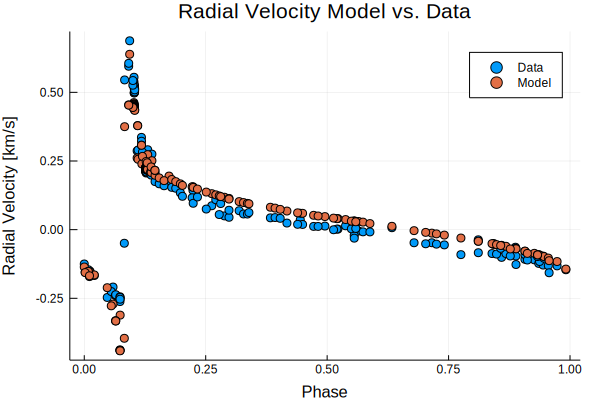

In [27]:
# Plot the best-fit model

# Defining variables
M = (2 * pi./ P) * (time.- t_p)
E = FIND_E.(M, e)
f = 2 * atan.(((1 + e)/(1 - e))^(1/2) * tan.(E./2))

Vrad = h.* cos.(f).+ c.* sin.(f).+ V0
time_step = (time.- minimum(time))./ FIND_P(time,RV)

println("Period: ", FIND_P(time, RV), " days")
println("Eccentricity: ", e)
println("Time of Periastron: ", t_p)
println("K: ", sqrt(h^2+c^2))
println("gamma: ", V0.-h.* e)

RV_data_model = hcat(RV, Vrad)
plot(phase, RV_data_model, seriestype=:scatter, label = ["Data" "Model"],
        title="Radial Velocity Model vs. Data", xlabel="Phase", ylabel="Radial Velocity [km/s]")